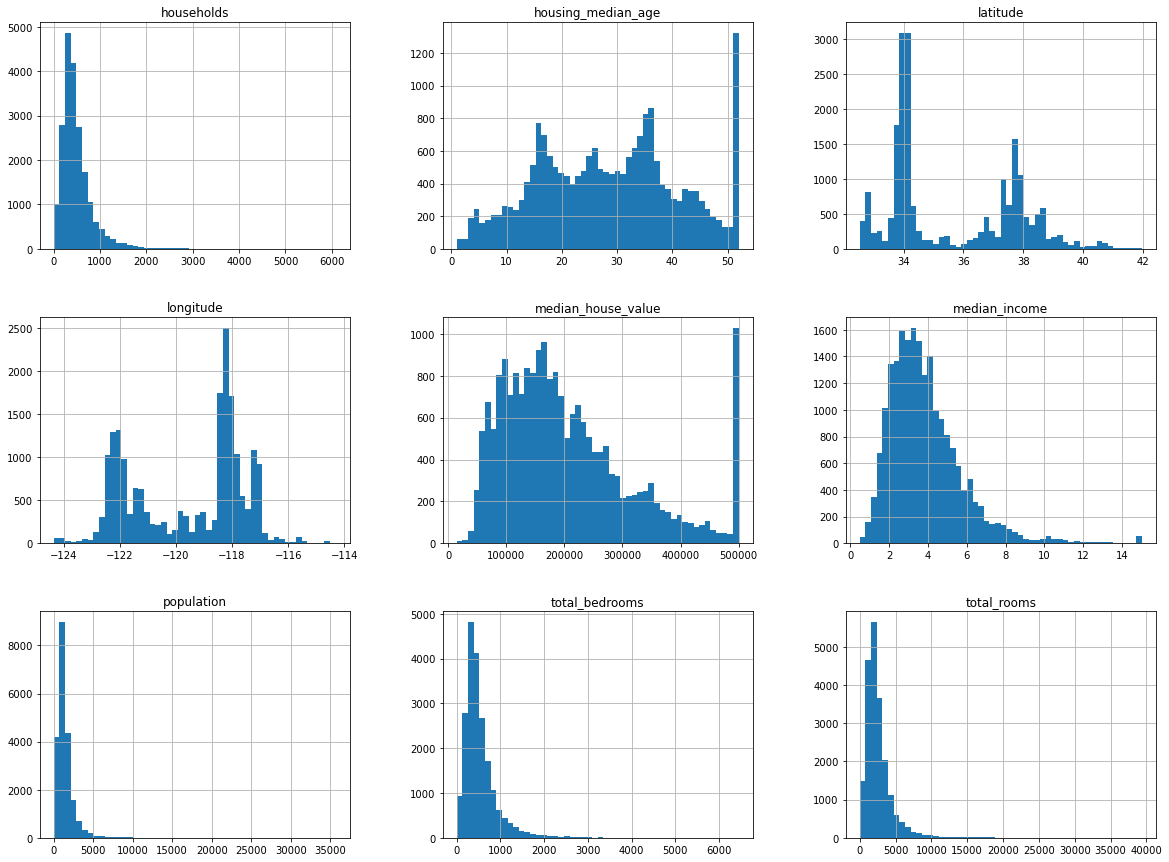

In [18]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Acquire housing data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# Load housing data into Pandas Dataframe
def load_housing_data(housing_path=HOUSING_PATH):
    fetch_housing_data()
    csv_path=os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

# Ensure that records from the test set are not added back into the train set via randomization
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# Split data into testing and training portions (20% testing, 80% training)
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Create Pandas dataframe
housing = load_housing_data()

# housing.head() # First 5 records shown
# housing.info() # Info function
# housing.describe() # describe function

# Histogram for data
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [19]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index") # Creates train/test sets
print(len(train_set)) # Print length of train
print(len(test_set)) # Print length of test

16512
4128


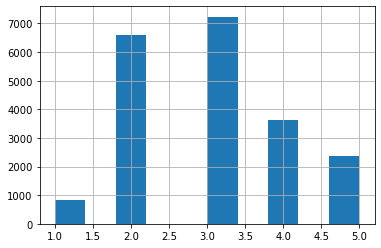

In [22]:
# The pd.cut() function is used to create an income category attribute with 5 categories (labeled from 1 to 5): category 1 ranges from # 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6.,np.inf], labels=[1,2,3,4,5])
housing["income_cat"].hist() # Histogram of income brackets

In [26]:
# Stratified sampling for income category (making sure the sample represents the population)
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Print out percentage of people in each income bracket after stratified sampling
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

# Remove "income_cat" to bring data back to original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1,inplace=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


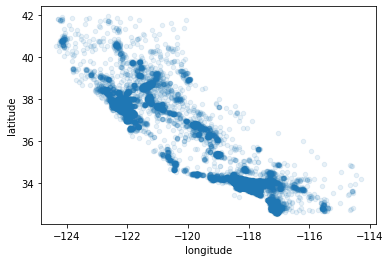

In [28]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)